In [1]:
import sys
import os
sys.path.append(r"D:\CursorProj\Chem-Ontology-Constructor")
os.environ["PROJECT_ROOT"] = "D:\\CursorProj\\Chem-Ontology-Constructor\\"

In [36]:
from owlready2 import *

from config.settings import _ONTOLOGY_CONFIG

onto = get_ontology(r"D:\CursorProj\Chem-Ontology-Constructor\data\ontology\backup-4.owl").load(only_local=True)
class_namespace = onto.get_namespace(_ONTOLOGY_CONFIG["namespace_classes_iri"])

In [13]:
import networkx as nx
import matplotlib.pyplot as plt


classes.catalysis
classes.catalysis
classes.ion_extraction
classes.ion_extraction
classes.responsive_material
classes.responsive_material
classes.anion_p_bonding
classes.anion_p_bonding
classes.halogen_bonding
classes.halogen_bonding
classes.aromatic_residue
classes.aromatic_residue
classes.l-proline_residue
classes.l-proline_residue
classes.pyridine
classes.pyridine
classes.naphthyridine
classes.naphthyridine
classes.diformyl_pyrrole_precursor
classes.diformyl_pyrrole_precursor
classes.tripodal_amine
classes.tripodal_amine
classes.pseudospherical_inner_cavity
classes.pseudospherical_inner_cavity
classes.pyridine_nitrogen_atom
classes.pyridine_nitrogen_atom
classes.naphthyridine_nitrogen_atom
classes.naphthyridine_nitrogen_atom
classes.electrostatic_interaction
classes.electrostatic_interaction
classes.hydrogen_bonding
classes.hydrogen_bonding
classes.anion_p_bonding
classes.anion_p_bonding
classes.halogen_bonding
classes.halogen_bonding
classes.urea
classes.urea
classes.amide
classes.

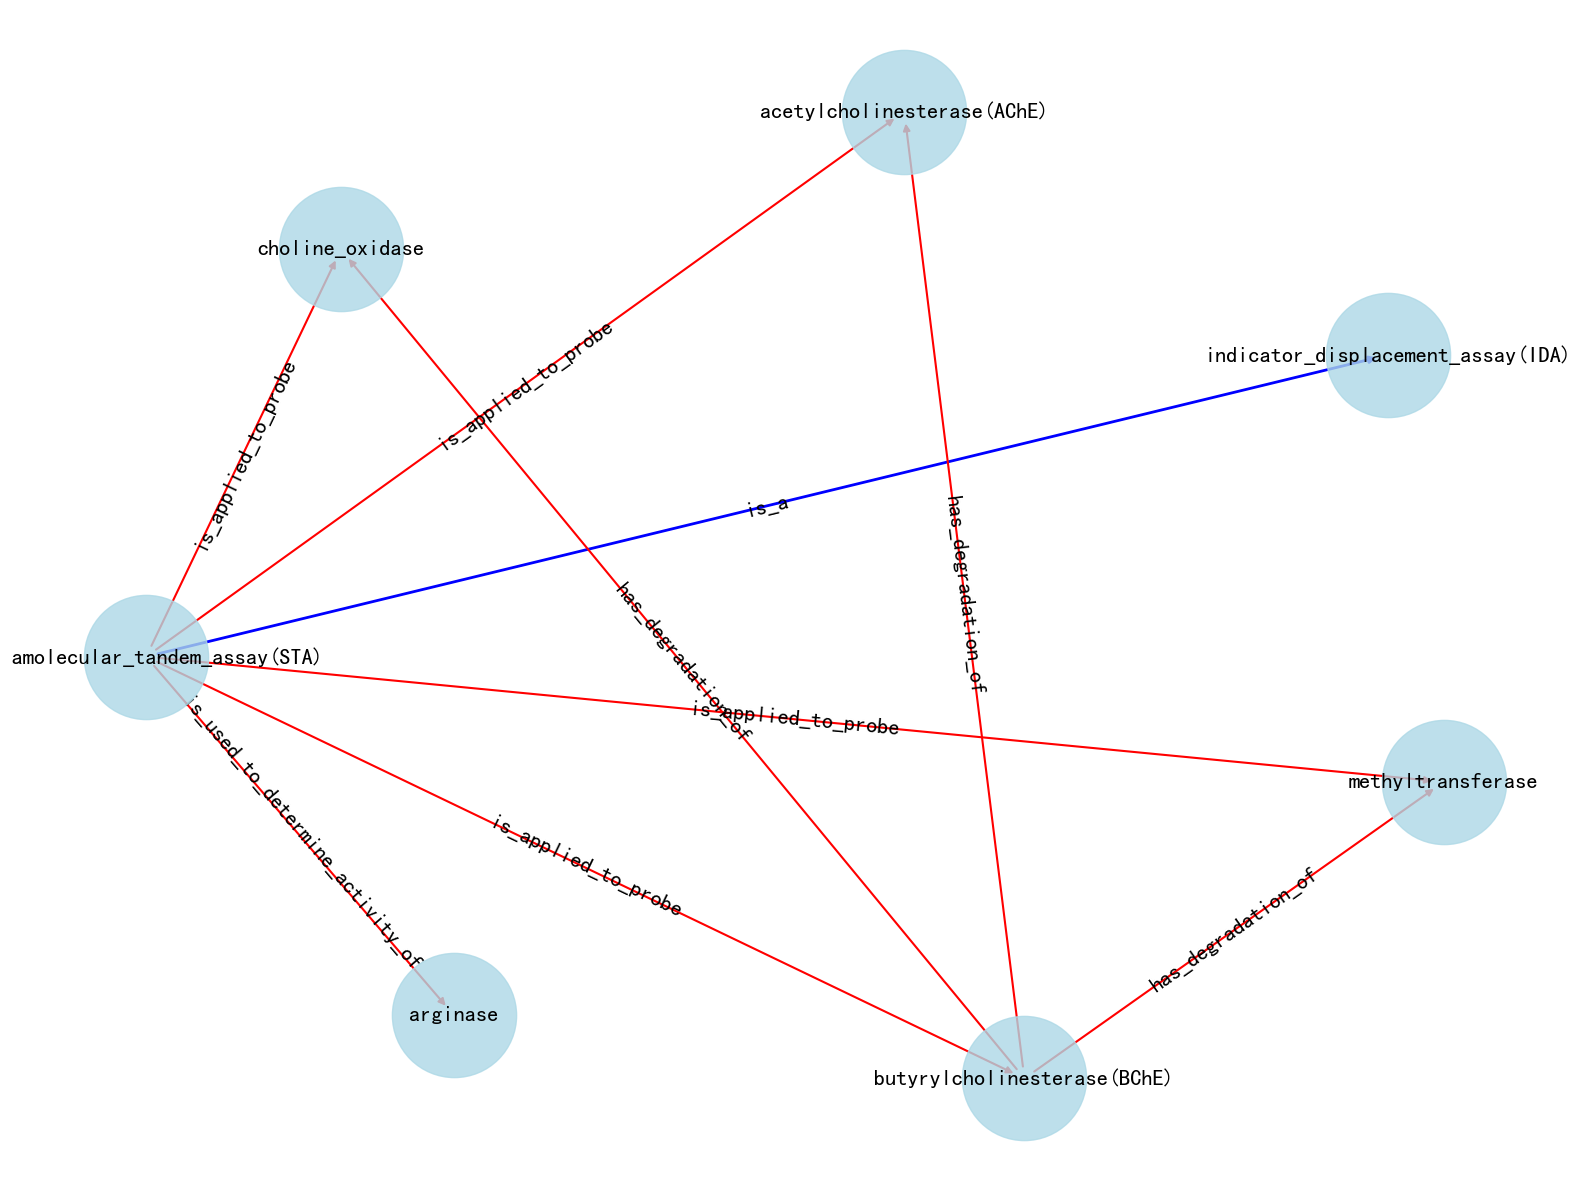

In [136]:
# ... existing code ...

# 创建一个NetworkX图
G = nx.DiGraph()

# 获取本体中的所有类
classes = list(onto.classes())
# 选择形成簇的节点，优先考虑对象属性关系
def get_clustered_classes(all_classes, max_nodes=15):
    # 创建临时图来分析类的关系
    temp_G = nx.Graph()
    
    # 添加所有类作为节点
    for cls in all_classes:
        temp_G.add_node(cls)
    
    # 添加继承关系作为边
    for cls in all_classes:
        for parent in cls.is_a:
            if parent in all_classes:
                temp_G.add_edge(cls, parent, weight=0.1)  # 继承关系权重较低
    
    # 添加对象属性关系作为边
    for cls in all_classes:
        for prop in cls.is_a:
            if isinstance(prop, owlready2.class_construct.Restriction) :
                if isinstance(prop.value, owlready2.class_construct.LogicalClassConstruct):
                    for range_cls in prop.value.Classes:
                        print(range_cls)
                        if range_cls in all_classes:
                            print(range_cls)
                            temp_G.add_edge(cls, range_cls, weight=2)  # 对象属性权重较高
                elif isinstance(prop.value, owlready2.entity.ThingClass):
                    if prop.value in all_classes:
                        temp_G.add_edge(cls, prop.value, weight=2)  # 对象属性权重较高
    
    # 使用社区检测算法找到簇
    try:
        # 尝试使用Louvain算法进行社区检测
        import community as community_louvain
        partition = community_louvain.best_partition(temp_G)
        
        # 按社区分组
        communities = {}
        for node, community_id in partition.items():
            if community_id not in communities:
                communities[community_id] = []
            communities[community_id].append(node)
        
        # 将社区转换为列表并按大小排序
        community_list = list(communities.values())
        community_list.sort(key=len, reverse=True)
    except:
        # 如果Louvain算法不可用，退回到连通分量
        community_list = list(nx.connected_components(temp_G))
        community_list.sort(key=len, reverse=True)
    
    # 从最大的社区中选择节点
    selected = set()
    for community in community_list[:3]:  # 从前三个最大的社区中选择
        # 从每个社区中选择一定数量的节点
        selected.update(list(community)[:max_nodes//3 + 1])
        if len(selected) >= max_nodes:
            break
    
    # 如果节点不足，从其他社区添加
    if len(selected) < max_nodes and len(community_list) > 3:
        for community in community_list[3:]:
            selected.update(list(community)[:max_nodes-len(selected)])
            if len(selected) >= max_nodes:
                break
    
    return list(selected)

# 获取形成簇的类
selected_classes = get_clustered_classes(classes, max_nodes=18)  # 增加节点数以获得更好的簇
print(f"已选择 {len(selected_classes)} 个类用于可视化")

# 添加节点
for cls in selected_classes:
    G.add_node(cls.name)
print(f"已添加 {len(selected_classes)} 个类节点")

# 添加边 - 基于类的继承关系
inheritance_count = 0
for cls in selected_classes:
    for parent in cls.is_a:
        if hasattr(parent, 'name') and parent in classes:
            if parent not in selected_classes:
                G.add_node(parent.name)
            G.add_edge(cls.name, parent.name, edge_type='继承关系', label='is_a')
            inheritance_count += 1
    for child in cls.subclasses():
        if child in classes:
            if child not in selected_classes:
                G.add_node(child.name)
                print('添加', child.name)
            G.add_edge(cls.name, child.name, edge_type='继承关系', label='has_child')
            inheritance_count += 1
print(f"已添加 {inheritance_count} 个继承关系边")

# 添加数据属性关系
data_property_count = 0
for cls in selected_classes:
    for prop in cls.get_class_properties():
        if prop.is_a and len(prop.is_a) > 0 and prop.is_a[0] == onto.DatatypeProperty:
            # 只处理当前类定义的数据属性，不包括继承的
            if cls in getattr(prop, 'domain', []):
                G.add_edge(cls.name, f"{prop.name}", edge_type='数据属性')
                G.add_node(f"{prop.name}", node_type='数据属性')
                data_property_count += 1
print(f"已添加 {data_property_count} 个数据属性节点和边")

# 添加对象属性关系
object_property_count = 0
object_property_types = {}  # 记录不同对象属性的出现次数
for cls in selected_classes:
        for prop in cls.is_a:
            if isinstance(prop, owlready2.class_construct.Restriction) :
                if isinstance(prop.value, owlready2.class_construct.LogicalClassConstruct):
                    for range_cls in prop.value.Classes:
                        if range_cls in classes:
                            G.add_edge(cls.name, range_cls.name, edge_type='对象属性', label=prop.property.name)
                            object_property_count += 1
                elif isinstance(prop.value, owlready2.entity.ThingClass):
                    if prop.value in classes:
                        G.add_edge(cls.name, prop.value.name, edge_type='对象属性', label=prop.property.name)
                        object_property_count += 1
                        
                        # 统计不同对象属性的出现次数
                        if prop.property.name in object_property_types:
                            object_property_types[prop.property.name] += 1
                        else:
                            object_property_types[prop.property.name] = 1
print(f"已添加 {object_property_count} 个对象属性关系边")

# 移除特定的边
# 这里我们可以根据需要移除特定的边，例如移除某个特定的对象属性关系
# 假设我们要移除从'ClassA'到'ClassB'的边
source_node = r'butyrylcholinesterase(BChE)'  # 替换为实际要移除的源节点名称
target_node = r'butyrylcholinesterase(BChE)'  # 替换为实际要移除的目标节点名称

if G.has_edge(source_node, target_node):
    G.remove_edge(source_node, target_node)
    print(f"已移除从 {source_node} 到 {target_node} 的边")
else:
    print(f"未找到从 {source_node} 到 {target_node} 的边")

# 输出对象属性的统计信息
if object_property_types:
    print("\n对象属性类型统计:")
    for prop_name, count in sorted(object_property_types.items(), key=lambda x: x[1], reverse=True):
        print(f"  - {prop_name}: {count}个关系")

# 移除孤立节点（没有任何连接的节点）
isolated_nodes = list(nx.isolates(G))
G.remove_nodes_from(isolated_nodes)
print(f"已移除 {len(isolated_nodes)} 个孤立节点")

# 只保留最大的连通分量（最大的簇）
if not nx.is_weakly_connected(G):
    largest_cc = max(nx.weakly_connected_components(G), key=len)
    nodes_to_remove = [n for n in G.nodes() if n not in largest_cc]
    G.remove_nodes_from(nodes_to_remove)
    print(f"已移除 {len(nodes_to_remove)} 个非最大连通分量的节点")

# 输出最终图的统计信息
print(f"\n最终图统计信息:")
print(f"  - 节点总数: {G.number_of_nodes()}")
print(f"  - 边总数: {G.number_of_edges()}")
print(f"  - 类节点数: {len([n for n in G.nodes() if not G.nodes[n].get('node_type')])}")
print(f"  - 数据属性节点数: {len([n for n in G.nodes() if G.nodes[n].get('node_type') == '数据属性'])}")
print(f"  - 平均节点度: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")


# 设置中文字体支持
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 用黑体显示中文
matplotlib.rcParams['axes.unicode_minus'] = False    # 正常显示负号

# 设置可视化参数
plt.figure(figsize=(16, 12))

# 使用社区检测算法来布局，以更好地显示簇
try:
    # 尝试使用kamada_kawai_layout，它通常更好地保留簇结构
    pos = nx.kamada_kawai_layout(G)
    print("使用kamada_kawai_layout成功")
except:
    # 如果失败，退回到spring_layout
    pos = nx.spring_layout(G, k=50, iterations=500)
    print("使用spring_layout成功")

# 获取不同类型的边
inheritance_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('edge_type') == '继承关系']
data_property_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('edge_type') == '数据属性']
object_property_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('edge_type') == '对象属性']

# 获取不同类型的节点
class_nodes = [n for n in G.nodes() if not G.nodes[n].get('node_type')]
data_property_nodes = [n for n in G.nodes() if G.nodes[n].get('node_type') == '数据属性']

# 绘制不同类型的节点
nx.draw_networkx_nodes(G, pos, nodelist=class_nodes, node_color='lightblue', node_size=8000, alpha=0.8)
nx.draw_networkx_nodes(G, pos, nodelist=data_property_nodes, node_color='lightgreen', node_size=1500, alpha=0.8)

# 绘制不同类型的边
nx.draw_networkx_edges(G, pos, edgelist=inheritance_edges, edge_color='blue', width=2,arrows=True)
nx.draw_networkx_edges(G, pos, edgelist=data_property_edges, edge_color='green', width=1.5, style='dashed')
nx.draw_networkx_edges(G, pos, edgelist=object_property_edges, edge_color='red', width=1.5)

# 添加边的标签（对象属性名称），设置背景透明
edge_labels = {(u, v): d['label'] for u, v, d in G.edges(data=True) if 'label' in d}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=16, font_family='SimHei', bbox=dict(alpha=0))

# 添加节点标签
nx.draw_networkx_labels(G, pos, font_size=16, font_weight='bold', font_family='SimHei')

# 添加图例
# plt.legend([
#     plt.Line2D([0], [0], color='blue', linewidth=2),
#     plt.Line2D([0], [0], color='green', linewidth=1.5, linestyle='--'),
#     plt.Line2D([0], [0], color='red', linewidth=1.5),
#     plt.Rectangle((0,0), 1, 1, fc='lightblue'),
#     plt.Rectangle((0,0), 1, 1, fc='lightgreen')
# ], ['继承关系', '数据属性', '对象属性', '类', '数据属性节点'], loc='upper right', fontsize=16)

# 设置透明背景
plt.gca().set_facecolor('none')
plt.gcf().set_facecolor('none')

# 显示图形
# plt.title("本体子图可视化", fontproperties='SimHei')
plt.axis('off')
plt.tight_layout()
plt.show()

In [92]:
class1 = class_namespace["anion_sensor"] #anion_sensor arginase

In [93]:
isinstance(class1.is_a[1], owlready2.class_construct.Restriction
)


True

In [94]:
type(class1.is_a[1].value)

owlready2.entity.ThingClass

In [44]:
for prop in class1.get_class_properties():
    print(prop)
    if prop.is_a and len(prop.is_a) > 0 and prop.is_a[0] == owl.ObjectProperty:
        print(prop)


meta.information
meta.source
object_properties.is_catalyzed_by


In [60]:
prop = list(class1.get_class_properties())[2]
class1.prop.name

AttributeError: 'prop' property is not defined.